In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

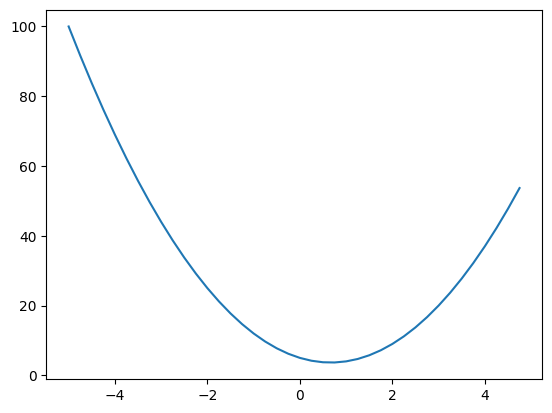

In [3]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [4]:
class Value:
  def __init__(self,data,_children=(),_op='',label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self._backward = lambda: None

  def __repr__(self) -> str:
    return f"Value(data={self.data})"

  def __sub__(self,other):
    return self + (-other)

  def __rmul__(self,other):
    return self * other

  def __radd__(self, other):
    return self.__add__(other)

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data,(self,other),'+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out = Value(self.data * other.data,(self,other),'*')
    out._backward = _backward
    return out

  def __truediv__(self,other):
    return self * other**-1


  def __pow__(self,other):
    assert isinstance(other,(int,float))
    out = Value(self.data**other,(self,),f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other - 1)) * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t,(self,),'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [5]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0,label='f')
L = d*f; L.label = 'L'


In [6]:
from graphviz import Digraph


def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes,edges

def draw_dot(root):
  dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})

  nodes,edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid,label="{%s | data %.4f | grad %.4f}"%(n.label,n.data,n.grad),shape='record')
    if n._op:
      dot.node(name=uid+n._op,label=n._op)
      dot.edge(uid+n._op,uid)
  for n1,n2 in edges:
    dot.edge(str(id(n1)),str(id(n2))+n2._op)
  return dot

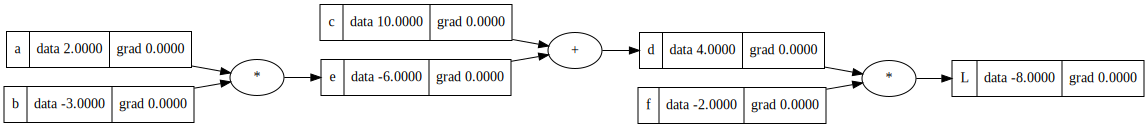

In [7]:
draw_dot(L)

In [8]:
L.grad = 1.0

In [9]:
## Typical linear neuron
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1;x1w1.label = "x1*w1"
x2w2= x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

In [10]:
o.backward()

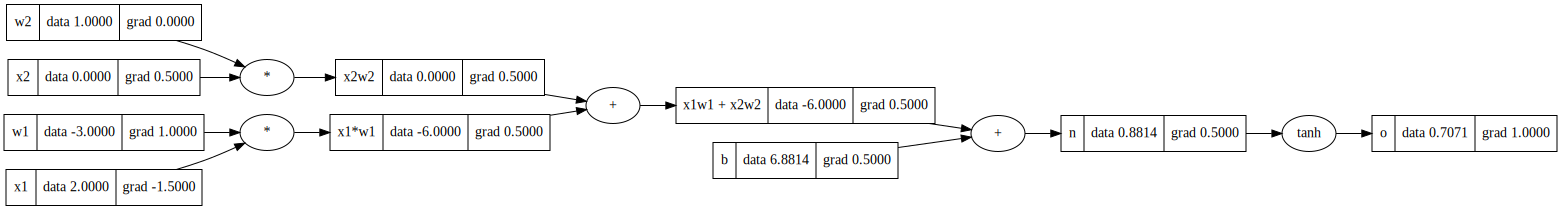

In [11]:
draw_dot(o)

In [ ]:
## manual backprop

o.grad = 1.0
n.grad = 1 - o.data**2
x1w1x2w2.grad = 0.5
b.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5
x2.grad = x2w2.grad * w2.data
w2.grad = x2.data * x2w2.grad
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

In [18]:
import random
class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b )
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

In [33]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.4589369967377124)

In [34]:
len(n.parameters()) # amount of parameters

41

In [54]:
xs = [
  [2.0,3.0,-1.0],
  [3.0,-1.0,0.5],
  [0.5,1.0,1.0],
  [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0] ## my desired targets

In [55]:
for k in range(20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))


  for p in n.parameters():
    p.grad = 0.0

  ## backward pass
  loss.backward()

  ## gradient descent
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k,loss.data)

0 1.0742370663767463e-11
1 1.074237065952623e-11
2 1.074237065662827e-11
3 1.0742370653023129e-11
4 1.0742370648852978e-11
5 1.074237064524784e-11
6 1.0742370641006608e-11
7 1.0742370638108644e-11
8 1.0742370634503505e-11
9 1.0742370631605542e-11
10 1.074237062701072e-11
11 1.0742370624112759e-11
12 1.0742370620507618e-11
13 1.0742370616337468e-11
14 1.0742370612732329e-11
15 1.0742370608491096e-11
16 1.0742370605593134e-11
17 1.0742370601987994e-11
18 1.0742370599090032e-11
19 1.0742370594848799e-11


In [49]:
ypred

[Value(data=0.9999999999999982),
 Value(data=-0.9999963235643032),
 Value(data=-0.9999939652206224),
 Value(data=0.9999999999999992)]